# MLP and Word Vectors

1. Implement MLP.
2. Implement Word2Vec


In [83]:
###############################################################
#                                                             #
#    Run this cell to make sure all packages are installed.   #
#                                                             #
###############################################################

# !pip install numpy pandas scikit-learn tqdm matplotlib
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

## 1. MLP
1. Data Processing 
2. MLP
3. Evaluation

### 1.1 Data Processing

#### load data

In [1]:
import pandas as pd

# training data
train_df = pd.read_csv('./data/train.csv', header=None)
train_df.columns = ['label', 'title', 'text']

# test data
test_df = pd.read_csv('./data/test.csv', header=None)
test_df.columns = ['label', 'title', 'text']

####  Preprocessing

In [2]:
import re
import string

class Preprocesser(object):
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number
    
    def apply(self, text):
        
        text = self._lowercase(text)
        
        if self.url:
            text = self._remove_url(text)
            
        if self.punctuation:
            text = self._remove_punctuation(text)
            
        if self.number:
            text = self._remove_number(text)
        
        text = re.sub(r'\s+', ' ', text)
            
        return text
    
        
    def _remove_punctuation(self, text):
        ''' Please fill this function to remove all the punctuations in the text
        '''
        text = text.translate(str.maketrans('','', string.punctuation))
        return text
    
    def _remove_url(self, text):
        ''' Please fill this function to remove all the urls in the text
        '''
        text = re.sub(r'\S*https?:\S*','',text)
 
        return text
    
    def _remove_number(self, text):
        ''' Please fill this function to remove all the numbers in the text
        '''
        text = text.translate(str.maketrans('','', string.digits))
        
        return text
    
    def _lowercase(self, text):
        ''' Please fill this function to lowercase the text
        '''
        text = text.lower()
        
        return text

#### Tokenization

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    ''' Please fill this function to tokenize text.
            1. Tokenize the text.
            2. Remove stop words.
            3. Optional: lemmatize words accordingly.
    '''
    
    stop_words = nlp.Defaults.stop_words
    tokens = text.strip().split()
#     tokens = nlp(text)
#     tokens = re.split(r"\W+", text.strip())

    tokens = [token for token in tokens if not token in stop_words]

        
    return tokens

#### Data Split

In [4]:
from sklearn.model_selection import train_test_split

text_train = train_df['text'].values.astype(str)
label_train = train_df['label'].values.astype(int) - 1 # -1 because labels start from 1

text_test = test_df['text'].values.astype(str)
label_test = test_df['label'].values.astype(int) - 1 # -1 because labels start from 1


text_train, text_valid, label_train, label_valid = train_test_split(text_train, label_train, test_size=0.2)


print('The size of training set:', text_train.shape[0])
print('The size of validation set:', text_valid.shape[0])
print('The size of testing set:', text_test.shape[0])

The size of training set: 96000
The size of validation set: 24000
The size of testing set: 7600


#### Feature Extraction

In [5]:
from collections import defaultdict
import numpy as np
from tqdm.notebook import tqdm

class TfIdfExtractor(object):
    
    def __init__(self, vocab_size=None):
        self.vocab_size = vocab_size
        
        self.vocab = defaultdict(lambda: 0)
        self.word2idx = {}
        self.df = defaultdict(lambda: 0)
        self.num_doc = 0
        
        self.processer = Preprocesser()
        
        
    def fit(self, texts):
        ''' 
                1. Construct the vocabulary (self.vocab).
                2. Construct the document frequency dictionary (self.df).
                3. Sort the vocabulary based on the frequency (self.vocab).
            Input:
                texts: a list of text (training set)
            Output:
                None
        '''

        self.num_doc = len(texts)
        
        for text in tqdm(texts, desc='fitting text'):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)
            
            # add unique words in vocab
            self.vocab.update({token:0 for token in tokens})
            # get frequency of words in each document
            self.df.update({token:self.df[token]+1 for token in set(tokens)})

        # sort vocabulary based on document frequency
        self.vocab = dict(sorted(self.vocab.items(), key=lambda x: self.df[x[0]], reverse=True))
                
        if self.vocab_size is not None:
            self.vocab = {key: self.vocab[key] for key in list(self.vocab.keys())[:self.vocab_size]}
        
        self.word2idx = {key: idx for idx, key in enumerate(self.vocab.keys())}


    def transform(self, texts):
        ''' 
            Input:
                texts: a list of text.
            Ouput:
                a N-d matrix (Tf-Idf) 
        '''
        tfidf = np.zeros((len(texts), len(self.vocab)))
        
        for i, text in tqdm(enumerate(texts), desc='transforming', total=len(texts)):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)
            
            # calculate term frequncy 
            tf = [tokens.count(word)/len(tokens) for idx,word in enumerate(self.word2idx.keys())]
            idf = [np.log((self.num_doc)/(self.df[word]+1)) for idx,word in enumerate(self.word2idx.keys())]
            # tfidf[i] = tf*idf
            tfidf[i] = np.array([x*y for x,y in zip(tf,idf)])

        
        return tfidf
                

#### Obtain the outputs

In [7]:
# You can change this number to see the difference of the performances. (larger vocab size needs more memory)
vocab_size = 4000
num_class = 4

extractor = TfIdfExtractor(vocab_size=vocab_size)
extractor.fit(text_train)

x_train = extractor.transform(text_train)
x_valid = extractor.transform(text_valid)
x_test = extractor.transform(text_test)


# convert label to one-hot vector
y_train = np.zeros((label_train.shape[0], num_class))
y_train[np.arange(label_train.shape[0]), label_train] = 1

y_valid = np.zeros((label_valid.shape[0], num_class))
y_valid[np.arange(label_valid.shape[0]), label_valid] = 1

y_test = np.zeros((label_test.shape[0], num_class))
y_test[np.arange(label_test.shape[0]), label_test] = 1


print('The size of training set:', x_train.shape)
print('The size of validation set:', x_valid.shape)
print('The size of test set:', x_test.shape)

fitting text:   0%|          | 0/96000 [00:00<?, ?it/s]

transforming:   0%|          | 0/96000 [00:00<?, ?it/s]

transforming:   0%|          | 0/24000 [00:00<?, ?it/s]

transforming:   0%|          | 0/7600 [00:00<?, ?it/s]

The size of training set: (96000, 4000)
The size of validation set: (24000, 4000)
The size of test set: (7600, 4000)


### 1.2 MLP 

#### 1.2.1 Implement MLP

> $z_1 = w_1x$

> $h_1 = activation(z_1)$

> $z_2 = w_2 h_1$

> $\hat{y} = softmax(z_2)$

In [8]:
class MLP(object):
    
    def __init__(self, num_feature, hidden_size, num_class):
        ''' Initialize the weight of MLP.
            Inputs:
                num_feature: scalar, the number of features (in this case, it is the vocab size).
                hidden_size: scaler, the number of neurons in the hidden layer.
                num_class: scalar, the number of classes.
        '''
                
        self.w1 = np.random.rand(num_feature, hidden_size)
        self.w2 = np.random.rand(hidden_size, num_class)
        
        
    def forward(self, x):
        ''' Implement the forward pass.
            Input:
                x: N-d matrix
            Outputs
                y_hat: the output of the model, N-K matrix.
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
                
                Note that the reason for return h1 and z1 is for calculating the gradient of self.w1 and self.w2.
                Feel free to change it accordingly.
        '''
        
        z1 = np.dot(x,self.w1)
        h1 = self.activation(z1)
        y_hat = self.softmax(np.dot(h1,self.w2)).squeeze()
        
        return y_hat, (h1, z1)
    
    
    def backward(self, lr, x, y, y_hat, h1, z1):
        ''' Implement back-propagation.
            Inputs:
                lr: learning rate.
                x: the input, N-d matrix.
                y_hat: the output, N-K matrix.
                y: ground truth (N-K one-hot matrix).
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
        '''

        # Get the gradient of w1 and w2
        grad_w1, grad_w2 = self.gradient(x, y, y_hat, h1, z1)
        
        # Gradient descent
        self.w1 -= lr * grad_w1
        self.w2 -= lr * grad_w2
        
    
    def objective(self, y, y_hat):
        ''' Compute the loss
            Inputs:
                y: N-K matrix, ground truth.
                y_hat: N-K matrix, prediction.
            Output:
                loss: scalar, the loss of the model.
        '''
        
        loss = 0.
        
        loss = -np.mean(np.sum(y * np.log(y_hat),axis=1))
        
        return loss
    
    
    def gradient(self, x, y, y_hat, h1, z1):
        ''' Compute the gradient of self.w1 and self.w2
            Inputs:
                x: the input, N-d matrix.
                y_hat: the output, N-K matrix.
                y: ground truth (N-K one-hot matrix).
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
            Outputs:
                grad_w1: the gradient of self.w1.
                grad_w2: the gradient of self.w2.
        '''
        n = x.shape[0]
        
        
        grad_w1 = (1/n)*np.dot(x.T,((h1*(1 - h1))*np.dot((y_hat - y),self.w2.T)))
        grad_w2 = (1/n)*np.dot(h1.T,(y_hat - y))
        
        
        return grad_w1, grad_w2
    
    
    def activation(self, x):
        ''' Implement the Sigmoid activation function .
            
            Input:
                x: N-d matrix
            Output:
                x: sigmoid(x) or ReLU(x)
        '''
        
        # sigmoid
        x = 1 / (1 + np.exp(-x))
        
        
        return x
    
    
    def softmax(self, x):
        if len(x.shape) == 1:
            x = x - np.max(x)
            return np.exp(x) / np.sum(np.exp(x))
        else:
            x = x - np.max(x, axis=1).reshape(-1, 1)
        return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)

    
    

#### 1.2.2 Optimization 

In [10]:
def optimization(model, X, y, lr, batch_size=None, num_epoch=100):
    ''' Implement Mini-batch GD
        Inputs:
            X: N-d matrix
            y: N vector
            lr: learning rate
            batch_size: optional, depends on if you use Mini-batch GD
            num_epoch: the number of epochs
        Output:
            A list of training losses against epoch
            A list of validation losses against epoch
    '''
    train_losses = []
    valid_losses = []
    
    n, _ = X.shape
    
    for e in range(num_epoch):
        train_loss = 0.
        
        losses = []
        
        rand_indices = np.random.permutation(n)
        x_rand = X[rand_indices]
        y_rand = y[rand_indices]
        
        for b in tqdm(range(0, n, batch_size), f'Epoch {e+1}/{num_epoch}'):
            x_batch = x_rand[b: b+batch_size] 
            y_batch = y_rand[b: b+batch_size]
            
            
            ### Step 1, call forward function to get outputs
            y_hat, (h1, z1) = model.forward(x_batch)
            
            ### Step 2, call objective function to get loss
            loss = model.objective(y_batch, y_hat)
            
            ### Step 3, call backward to update the weights
            model.backward(lr, x_batch, y_batch, y_hat, h1, z1)
            
            
            losses.append(loss)
        
        train_loss = np.mean(losses)
        
        
        y_hat, _ = model.forward(x_valid)
        valid_loss = model.objective(y_valid, y_hat)
        
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'At epoch {e+1}, training loss: {train_loss:.4f}, validation loss: {valid_loss:.4f}.')
            
    return train_losses, valid_losses

In [15]:
num_epoch = 100
lr = 0.01
batch_size = 32
hidden_size = 50

model = MLP(vocab_size, hidden_size, num_class)
train_losses, valid_losses = optimization(model, x_train, y_train, lr, batch_size=batch_size, num_epoch=num_epoch)

Epoch 1/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 1, training loss: 1.3912, validation loss: 1.3880.


Epoch 2/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 2, training loss: 1.3840, validation loss: 1.3841.


Epoch 3/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 3, training loss: 1.3793, validation loss: 1.3757.


Epoch 4/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 4, training loss: 1.3745, validation loss: 1.3707.


Epoch 5/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 5, training loss: 1.3691, validation loss: 1.3711.


Epoch 6/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 6, training loss: 1.3637, validation loss: 1.3588.


Epoch 7/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 7, training loss: 1.3578, validation loss: 1.3550.


Epoch 8/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 8, training loss: 1.3512, validation loss: 1.3466.


Epoch 9/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 9, training loss: 1.3441, validation loss: 1.3389.


Epoch 10/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 10, training loss: 1.3362, validation loss: 1.3325.


Epoch 11/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 11, training loss: 1.3271, validation loss: 1.3246.


Epoch 12/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 12, training loss: 1.3168, validation loss: 1.3135.


Epoch 13/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 13, training loss: 1.3051, validation loss: 1.2988.


Epoch 14/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 14, training loss: 1.2922, validation loss: 1.2842.


Epoch 15/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 15, training loss: 1.2776, validation loss: 1.2730.


Epoch 16/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 16, training loss: 1.2615, validation loss: 1.2520.


Epoch 17/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 17, training loss: 1.2433, validation loss: 1.2349.


Epoch 18/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 18, training loss: 1.2230, validation loss: 1.2135.


Epoch 19/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 19, training loss: 1.2009, validation loss: 1.1904.


Epoch 20/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 20, training loss: 1.1769, validation loss: 1.1646.


Epoch 21/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 21, training loss: 1.1508, validation loss: 1.1407.


Epoch 22/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 22, training loss: 1.1232, validation loss: 1.1121.


Epoch 23/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 23, training loss: 1.0940, validation loss: 1.0818.


Epoch 24/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 24, training loss: 1.0634, validation loss: 1.0498.


Epoch 25/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 25, training loss: 1.0323, validation loss: 1.0180.


Epoch 26/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 26, training loss: 1.0003, validation loss: 0.9864.


Epoch 27/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 27, training loss: 0.9684, validation loss: 0.9549.


Epoch 28/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 28, training loss: 0.9364, validation loss: 0.9264.


Epoch 29/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 29, training loss: 0.9052, validation loss: 0.8927.


Epoch 30/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 30, training loss: 0.8746, validation loss: 0.8625.


Epoch 31/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 31, training loss: 0.8454, validation loss: 0.8341.


Epoch 32/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 32, training loss: 0.8171, validation loss: 0.8077.


Epoch 33/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 33, training loss: 0.7903, validation loss: 0.7809.


Epoch 34/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 34, training loss: 0.7648, validation loss: 0.7566.


Epoch 35/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 35, training loss: 0.7410, validation loss: 0.7340.


Epoch 36/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 36, training loss: 0.7185, validation loss: 0.7121.


Epoch 37/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 37, training loss: 0.6975, validation loss: 0.6964.


Epoch 38/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 38, training loss: 0.6778, validation loss: 0.6733.


Epoch 39/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 39, training loss: 0.6596, validation loss: 0.6562.


Epoch 40/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 40, training loss: 0.6426, validation loss: 0.6416.


Epoch 41/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 41, training loss: 0.6268, validation loss: 0.6258.


Epoch 42/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 42, training loss: 0.6122, validation loss: 0.6123.


Epoch 43/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 43, training loss: 0.5984, validation loss: 0.5980.


Epoch 44/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 44, training loss: 0.5858, validation loss: 0.5874.


Epoch 45/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 45, training loss: 0.5740, validation loss: 0.5753.


Epoch 46/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 46, training loss: 0.5631, validation loss: 0.5649.


Epoch 47/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 47, training loss: 0.5528, validation loss: 0.5557.


Epoch 48/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 48, training loss: 0.5433, validation loss: 0.5466.


Epoch 49/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 49, training loss: 0.5344, validation loss: 0.5398.


Epoch 50/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 50, training loss: 0.5260, validation loss: 0.5333.


Epoch 51/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 51, training loss: 0.5183, validation loss: 0.5237.


Epoch 52/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 52, training loss: 0.5109, validation loss: 0.5174.


Epoch 53/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 53, training loss: 0.5041, validation loss: 0.5105.


Epoch 54/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 54, training loss: 0.4976, validation loss: 0.5041.


Epoch 55/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 55, training loss: 0.4915, validation loss: 0.4988.


Epoch 56/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 56, training loss: 0.4857, validation loss: 0.4943.


Epoch 57/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 57, training loss: 0.4803, validation loss: 0.4887.


Epoch 58/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 58, training loss: 0.4751, validation loss: 0.4835.


Epoch 59/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 59, training loss: 0.4702, validation loss: 0.4799.


Epoch 60/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 60, training loss: 0.4656, validation loss: 0.4772.


Epoch 61/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 61, training loss: 0.4611, validation loss: 0.4719.


Epoch 62/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 62, training loss: 0.4569, validation loss: 0.4672.


Epoch 63/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 63, training loss: 0.4528, validation loss: 0.4641.


Epoch 64/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 64, training loss: 0.4490, validation loss: 0.4601.


Epoch 65/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 65, training loss: 0.4453, validation loss: 0.4569.


Epoch 66/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 66, training loss: 0.4419, validation loss: 0.4535.


Epoch 67/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 67, training loss: 0.4384, validation loss: 0.4508.


Epoch 68/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 68, training loss: 0.4352, validation loss: 0.4481.


Epoch 69/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 69, training loss: 0.4321, validation loss: 0.4456.


Epoch 70/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 70, training loss: 0.4291, validation loss: 0.4435.


Epoch 71/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 71, training loss: 0.4263, validation loss: 0.4401.


Epoch 72/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 72, training loss: 0.4234, validation loss: 0.4373.


Epoch 73/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 73, training loss: 0.4207, validation loss: 0.4352.


Epoch 74/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 74, training loss: 0.4182, validation loss: 0.4332.


Epoch 75/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 75, training loss: 0.4156, validation loss: 0.4308.


Epoch 76/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 76, training loss: 0.4133, validation loss: 0.4289.


Epoch 77/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 77, training loss: 0.4108, validation loss: 0.4269.


Epoch 78/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 78, training loss: 0.4085, validation loss: 0.4248.


Epoch 79/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 79, training loss: 0.4063, validation loss: 0.4228.


Epoch 80/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 80, training loss: 0.4042, validation loss: 0.4228.


Epoch 81/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 81, training loss: 0.4021, validation loss: 0.4196.


Epoch 82/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 82, training loss: 0.4001, validation loss: 0.4182.


Epoch 83/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 83, training loss: 0.3981, validation loss: 0.4161.


Epoch 84/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 84, training loss: 0.3962, validation loss: 0.4146.


Epoch 85/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 85, training loss: 0.3943, validation loss: 0.4136.


Epoch 86/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 86, training loss: 0.3926, validation loss: 0.4114.


Epoch 87/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 87, training loss: 0.3909, validation loss: 0.4110.


Epoch 88/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 88, training loss: 0.3891, validation loss: 0.4088.


Epoch 89/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 89, training loss: 0.3874, validation loss: 0.4071.


Epoch 90/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 90, training loss: 0.3858, validation loss: 0.4059.


Epoch 91/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 91, training loss: 0.3841, validation loss: 0.4048.


Epoch 92/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 92, training loss: 0.3824, validation loss: 0.4033.


Epoch 93/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 93, training loss: 0.3810, validation loss: 0.4019.


Epoch 94/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 94, training loss: 0.3795, validation loss: 0.4018.


Epoch 95/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 95, training loss: 0.3780, validation loss: 0.4002.


Epoch 96/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 96, training loss: 0.3766, validation loss: 0.3982.


Epoch 97/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 97, training loss: 0.3752, validation loss: 0.3977.


Epoch 98/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 98, training loss: 0.3738, validation loss: 0.3963.


Epoch 99/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 99, training loss: 0.3725, validation loss: 0.3951.


Epoch 100/100:   0%|          | 0/3000 [00:00<?, ?it/s]

At epoch 100, training loss: 0.3711, validation loss: 0.3940.


#### 1.2.3 Evaluation

In [16]:
from sklearn.metrics import precision_score, recall_score

y_hat, _ = model.forward(x_test)
y_hat = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)

print(y_true.shape)
precision = precision_score(y_true, y_hat, average=None)
recall = recall_score(y_true, y_hat, average=None)

print('MLP')
print()
print('  Precision:')
print(f'    class {0}: {precision[0]:.4f}, class {1}: {precision[1]:.4f}, class {2}: {precision[2]:.4f}, class {3}: {precision[3]:.4f}')
print()
print('  Recall:')
print(f'    class {0}: {recall[0]:.4f}, class {1}: {recall[1]:.4f}, class {2}: {recall[2]:.4f}, class {3}: {recall[3]:.4f}')

(7600,)
MLP

  Precision:
    class 0: 0.8797, class 1: 0.9303, class 2: 0.8289, class 3: 0.8395

  Recall:
    class 0: 0.8774, class 1: 0.9479, class 2: 0.8289, class 3: 0.8258


#### Run the following cell to plot the training loss and validation loss against epoch

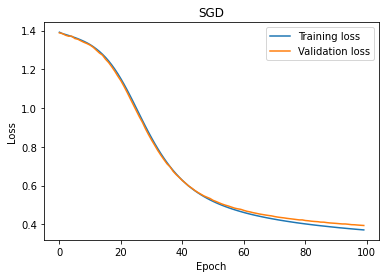

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline


plt.plot(range(num_epoch), train_losses, valid_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('SGD')
plt.show()

## 2. Word Vector

#### 2.2.1 Sigmoid Function

In [18]:
def sigmoid(x):
    ''' Compute the sigmoid function.
        Inputs:
            x: A scalar or numpy array
        Outputs:
            s: sigmoid(x)
    '''
    s = 0.
    
    s = 1 / (1 + np.exp(-x))

    return s


def softmax(x):
    ''' Compute the softmax function for each row of the input x. 
        It is crucial that this function is optimized for speed 
        because it will be used frequently in later code. 

        Inputs:
        x: A D dimensional vector or N x D dimensional numpy matrix.
        Outputs:
        x: You are allowed to modify x in-place
    '''
    if len(x.shape) == 1:
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    else:
        x = x - np.max(x, axis=1).reshape(-1, 1)
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
    

#### 2.2.2 Word2Vec models with Stochastic gradient descent (SGD)

#### Naive Softmax loss & gradient function for word2vec models

In [28]:
def naiveSoftmaxLossAndGradient(centerWordVec, outsideWordIdx, outsideVectors, dataset):
    ''' Implement tha naive softmax loss and gradients between a center word's embedding 
        and an outside word's embedding. This will be the building block for our word2vec
        models.
        
        Inputs:
            centerWordVec: numpy ndarray, center word's embedding (v_c in question 2.1.1).
            outsideWordIdx: integer, the index of the outside word (o of u_o in question 2.1.1).
            outsideVectors: outside vectors (rows of matrix) for all words in vocab (U in question 2.1.1).
            dataset: for negative sampling, ignore this argument in this function.
        
        Outputs:
            loss: naive softmax loss
            gradCenterVec: the gradient with respect to the center word vector (dJ/dv_c in question 2.1.1).
            gradOutsideVecs: the gradient with respect to all the outside word vectors (dJ / dU).
    '''
    
    y_hat = softmax(np.dot(outsideVectors,centerWordVec))
    loss = -np.log(y_hat[outsideWordIdx])
    y_hat[outsideWordIdx] -= 1.0
    gradCenterVec = np.dot(outsideVectors.T,y_hat)
    gradOutsideVecs = np.outer(y_hat,centerWordVec)
        
    return loss, gradCenterVec, gradOutsideVecs

#### Negative sampling loss function for word2vec models 

In [35]:
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

def negSamplingLossAndGradient(centerWordVec, outsideWordIdx, outsideVectors, dataset, K=10):
    ''' Implement the negative sampling loss and gradients for a centerWordVec
        and a outsideWordIdx word vector as a building block for word2vec
        models. K is the number of negative samples to take.

        Inputs/Outpus Specifications: same as naiveSoftmaxLossAndGradient
    '''
    
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices
    
    
    gradCenterVec, gradOutsideVecs = np.zeros(centerWordVec.shape),np.zeros(outsideVectors.shape)
    
    y_hat = sigmoid(np.dot(outsideVectors[outsideWordIdx],centerWordVec))
    loss = -np.log(y_hat)
    gradCenterVec += outsideVectors[outsideWordIdx] * (y_hat - 1.0)
    gradOutsideVecs[outsideWordIdx] = centerWordVec * (y_hat - 1.0)
    
    for i in range(K):
        y_hat = sigmoid(-np.dot(outsideVectors[indices[i+1]],centerWordVec))
        loss -= np.log(y_hat)
        gradCenterVec += outsideVectors[indices[i+1]] * (1.0 - y_hat)
        gradOutsideVecs[indices[i+1]] += centerWordVec * (1.0 - y_hat)
    
    
    return loss, gradCenterVec, gradOutsideVecs


#### Skip-gram model in word2vec

In [36]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    ''' Implement the skip-gram model in this function.
    
        Inputs:
            currentCenterWord: a string of the current center word
            windowSize: integer, context window size
            outsideWords: list of no more than 2*windowSize strings, the outside words
            word2Ind: a dictionary that maps words to their indices in
                      the word vector list
            centerWordVectors: center word vectors (as rows) for all words in vocab
                                (V in pdf handout)
            outsideVectors: outside word vectors (as rows) for all words in vocab
                            (U in pdf handout)
            word2vecLossAndGradient: the loss and gradient function for
                                       a prediction vector given the outsideWordIdx
                                       word vectors, could be one of the two
                                       loss functions you implemented above.

        Outputs:
            loss: the loss function value for the skip-gram model
                    (J in the pdf handout)
            gradCenterVecs: the gradient with respect to the center word vectors
                    (dJ / dV in the pdf handout)
            gradOutsideVectors: the gradient with respect to the outside word vectors
                                (dJ / dU in the pdf handout)
    '''
    
    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    i = word2Ind[currentCenterWord]
    centerWordVec = centerWordVectors[i]
    
    for ow in outsideWords:
        j = word2Ind[ow]
        ls, cnt_grad, out_grad = word2vecLossAndGradient(centerWordVec, j, outsideVectors, dataset)
        loss += ls
        gradCenterVecs[i] += cnt_grad
        gradOutsideVectors += out_grad



    return loss, gradCenterVecs, gradOutsideVectors



def normalizeRows(x):
    """ Row normalization function
    """
    N = x.shape[0]
    x /= np.sqrt(np.sum(x**2, axis=1)).reshape((N, 1)) + 1e-30
    return x


def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2), :]
    outsideVectors = wordVectors[int(N/2):, :]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

#### 2.2.3 K-nearest neighbors. (Fill the code: 10 points)

In [38]:
def cosine_similartiy(v1, v2):
    ''' return the cosine similarity of two vectors
        
        Inputs:
            v1: a numpy ndarray
            v2: a numpy ndarray
        Outputs:
            s: the cosine similarity of v1 and v2
    '''
    
    
    s = np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    
    return s

def knn(vec, mat, k):
    ''' 
        Inputs:
            vec: numpy ndarray, the target vector
            mat: numpy ndarray, a matrix contains all the vectors (each row is a vector)
            k: the number of the nearest neighbors you want to find.
            
        Outputs:
            indices: the k indices of the matrix's rows that are closest to the vec
    '''
                          
                          
    scores = np.array([cosine_similartiy(vec, v2) for v2 in mat])
    indices = (-scores).argsort()[:k]        
    
    
    return indices

#### 2.2.4 Evaluation of the model with visualization and knn

In [39]:
import os.path as op
import numpy as np
import random
import glob
import pickle

import time
from utils.treebank import StanfordSentiment

SAVE_PARAMS_EVERY = 5000


def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)


def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=1000):
    """ Stochastic Gradient Descent

    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss

    Return:
    x -- the parameter value after SGD finishes
    """

    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        def postprocessing(x): return x

    exploss = None

    last_time = time.time()
    for iter in range(start_iter + 1, iterations + 1):

        loss = None
        loss, g = f(x)
        x -= step * g

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f, duration %d" % (iter, exploss, int(time.time() - last_time)))
            last_time = time.time()

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

In [40]:
import time
from utils.treebank import StanfordSentiment

random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)


dimVectors = 10

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)

startTime = time.time()
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
     dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)

wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
                                     negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=100)

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

tokenizing:   0%|          | 0/10000 [00:00<?, ?it/s]

iter 100: 26.533652, duration 7
iter 200: 26.442153, duration 4
iter 300: 26.362852, duration 4
iter 400: 26.379029, duration 4
iter 500: 26.645997, duration 4
iter 600: 26.556476, duration 4
iter 700: 26.494382, duration 4
iter 800: 26.267603, duration 4
iter 900: 26.166555, duration 4
iter 1000: 26.139140, duration 4
iter 1100: 26.143564, duration 4
iter 1200: 26.140144, duration 4
iter 1300: 26.144551, duration 5
iter 1400: 26.133381, duration 5
iter 1500: 26.099830, duration 4
iter 1600: 25.984087, duration 4
iter 1700: 25.973000, duration 5
iter 1800: 25.832863, duration 4
iter 1900: 25.706221, duration 3
iter 2000: 25.661754, duration 3
iter 2100: 25.658153, duration 3
iter 2200: 25.593158, duration 4
iter 2300: 25.559810, duration 3
iter 2400: 25.474018, duration 3
iter 2500: 25.276726, duration 3
iter 2600: 25.431643, duration 4
iter 2700: 25.358022, duration 4
iter 2800: 25.357574, duration 4
iter 2900: 25.299071, duration 4
iter 3000: 25.262539, duration 4
iter 3100: 25.13541

#### Run the following cell to obtain the visulaization of words

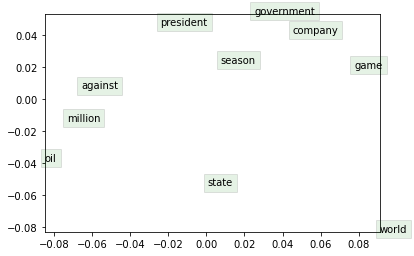

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

# concatenate the input and output word vectors
wordVectors = np.concatenate(
    (wordVectors[:nWords, :], wordVectors[nWords:, :]),
    axis=0)

visualizeWords = [
    'state', 'season', 'company', 'world', 'against', 
    'president', 'game', 'million', 'oil', 'government'
]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U, S, V = np.linalg.svd(covariance)
coord = temp.dot(U[:, 0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i, 0], coord[i, 1], visualizeWords[i],
             bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))

plt.savefig('word_vectors.png')
plt.show()

#### Run the following cell to obtain the k-nearest neighbors

In [42]:
centerVectors = wordVectors[:nWords, :]
outputVectors = wordVectors[nWords:, :]
for word in visualizeWords:
    idx = tokens[word]
    vec = outputVectors[idx]
    indices = knn(vec, outputVectors, 10)
    closed_words = [list(tokens.keys())[i] for i in indices]
    print('Word: "{}" is close to {}'.format(word, closed_words))

Word: "state" is close to ['state', 'down', 'making', 'late', 'centrino', 'berth', 'released', 'chipmakers', 'we', 'major']
Word: "season" is close to ['season', 'no', 'series', 'despite', 'strike', 'computer', 'notre', 'pence', 'months', 'services']
Word: "company" is close to ['company', 'step', 'neitzel', 'sylvester', 'customer', 'you', 'guyler', 'tells', 'contrast', 'brisk']
Word: "world" is close to ['world', 'saturday', 'ghz', 'karzai', 'late', 'sentenced', 'deliberations', 'bcn', 'business', 'instruments']
Word: "against" is close to ['against', 'must', 'place', 'costs', 'another', 'primarily', 'certainty', 'cancun', 'annoying', 'rolled']
Word: "president" is close to ['president', 'renegade', 'rican', 'myriad', 'door', 'tendering', 'founded', 'newton', 'democracy', 'flowers']
Word: "game" is close to ['game', 'broke', 'loss', 'economy', 'appeared', 'guys', 'companies', 'spoornet', 'lions', 'carve']
Word: "million" is close to ['million', 'penalties', 'rising', 'appreciation', '